In [1]:
import re
import gc
import os
import cv2
import copy
import glob
import time
import pickle
import random
import shutil
import urllib
import pathlib
import datetime
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from scipy import linalg
from sklearn.metrics import *
from collections import Counter
from scipy.stats import truncnorm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder

import torch
import torch as th
import torch.nn as nn
import torch.utils.data
import torchvision as tv
import torch.nn.functional as F
import torchvision.models as models

from torch.optim import Adam
from torch.nn import Parameter

from torchvision.datasets import *
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
from torchvision.utils import save_image
from torchvision.datasets.folder import *
from torch.nn.functional import interpolate
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import Conv2d, BCEWithLogitsLoss, DataParallel, AvgPool2d, ModuleList, LeakyReLU, ConvTranspose2d, Embedding

begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

2023-05-07 12:55:49.067840: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 12:55:49.102462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 12:55:49.103388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 12:55:50.901487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data

In [2]:
KERNEL_START_TIME = time.time()

In [3]:
DATA_PATH = '../data/all-dogs/'
IMAGES_LIST = glob.glob(DATA_PATH + '*/*.jpg')
IMAGES = [p for p in IMAGES_LIST]
ANNOTATION_PATH = '../data/Annotation'

print('Number of doge images :', len(IMAGES))

Number of doge images : 20580


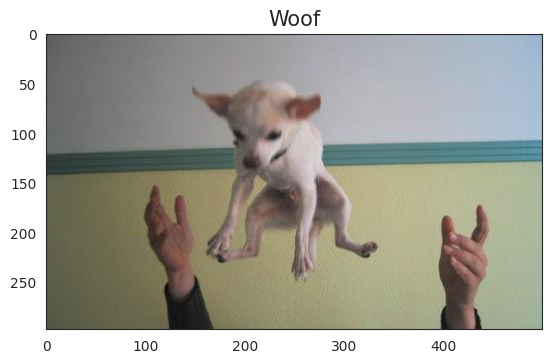

In [4]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.show()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [6]:
seed = 2019
seed_everything(seed)

# Datasets

In [7]:
class Rescale():
    def __init__(self):
        self.a = 2
        self.b = -1
        
    def __call__(self, tensor):
        return tensor.mul(self.a).add(self.b)

    def __repr__(self):
        return self.__class__.__name__ + '(x{}, +{})'.format(self.a, self.b)

In [8]:
def get_transforms(size):
    base_transforms = transforms.Compose([transforms.Resize(size)])
    additional_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomApply([transforms.RandomRotation(degrees=5)], p=0.5),
        transforms.RandomChoice([transforms.CenterCrop(size), transforms.RandomCrop(size)]),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=(0.9, 1.2), saturation=0.3, hue=0.01)], p=0.5),
        transforms.ToTensor(),
#         transforms.Normalize(means, stds),
        Rescale(),
    ])
    return base_transforms, additional_transforms

In [9]:
class DogeDataset(Dataset):
    def __init__(self, folder, base_transforms, additional_transforms):
        self.folder = folder
        self.classes = [dirname[10:] for dirname in os.listdir(ANNOTATION_PATH)]
        
        self.base_transforms = base_transforms
        self.additional_transforms = additional_transforms
        self.imgs, self.labels = self.load_subfolders_images(folder)
        
        le = LabelEncoder().fit(self.classes)
        self.y = torch.from_numpy(le.transform(self.labels)).long()
        self.classes = le.inverse_transform(range(len(self.classes)))
        
    def __getitem__(self, index):
        return self.additional_transforms(self.imgs[index]), self.y[index]

    def __len__(self):
        return len(self.imgs)
    
    @staticmethod
    def is_valid_file(x):
        img_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        return has_file_allowed_extension(x, img_extensions)
    
    @staticmethod
    def get_bbox(o):
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        return xmin, ymin, xmax, ymax
    
    @staticmethod
    def larger_bbox(bbox, ximg, yimg, a=10):
        xmin, ymin, xmax, ymax = bbox
        xmin = max(xmin - a, 0)
        ymin = max(ymin - a, 0)
        xmax = min(xmax + a, ximg)
        ymax = min(ymax + a, yimg)
        return (xmin, ymin, xmax, ymax)
    
    def load_subfolders_images(self, root):
        imgs = []
        paths = []
        labels = []
        
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if self.is_valid_file(path):
                    paths.append(path)

        for path in paths:
            img = default_loader(path)

            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(ANNOTATION_PATH) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(ANNOTATION_PATH, annotation_dirname, annotation_basename)
            label = annotation_dirname[10:]
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bbox = self.get_bbox(o)
                bbox = self.larger_bbox(bbox, img.size[0], img.size[1])
                object_img = self.base_transforms(img.crop(bbox))
                imgs.append(object_img)
                labels.append(label)
        return imgs, labels

In [10]:
%%time
base_transforms, additional_transforms = get_transforms(64)
dataset = DogeDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 48.3 s, sys: 5.66 s, total: 53.9 s
Wall time: 1min 29s


In [11]:
nb_classes = len(dataset.classes)
print(f'Number of classes : {nb_classes}')

Number of classes : 120


In [12]:
nb_dogs = len(dataset)
print(f'Number of dogs : {nb_dogs}')

Number of dogs : 22126


# Models

In [13]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### Equalized Layers

In [14]:
# extending Conv2D and Deconv2D layers for equalized learning rate logic
class _equalized_conv2d(th.nn.Module):
    """ conv2d with the concept of equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out:  output channels
            :param k_size: kernel size (h, w) should be a tuple or a single integer
            :param stride: stride for conv
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt, prod

        super(_equalized_conv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = prod(_pair(k_size)) * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv2d

        return conv2d(input=x,
                      weight=self.weight * self.scale,  # scale the weight on runtime
                      bias=self.bias if self.use_bias else None,
                      stride=self.stride,
                      padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_deconv2d(th.nn.Module):
    """ Transpose convolution using the equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out: output channels
            :param k_size: kernel size
            :param stride: stride for convolution transpose
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt

        super(_equalized_deconv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_in, c_out, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv_transpose2d

        return conv_transpose2d(input=x,
                                weight=self.weight * self.scale,  # scale the weight on runtime
                                bias=self.bias if self.use_bias else None,
                                stride=self.stride,
                                padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_linear(th.nn.Module):
    """ Linear layer using equalized learning rate
        Args:
            :param c_in: number of input channels
            :param c_out: number of output channels
            :param bias: whether to use bias with the linear layer
    """

    def __init__(self, c_in, c_out, bias=True):
        """
        Linear layer modified for equalized learning rate
        """
        from numpy import sqrt

        super(_equalized_linear, self).__init__()

        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in)
        ))

        self.use_bias = bias

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import linear
        return linear(x, self.weight * self.scale,
                      self.bias if self.use_bias else None)

### Pixelwise Normalization

In [15]:
class PixelwiseNorm(th.nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

### Minibatch Standard Deviation

In [16]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """
    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)

        # return the computed values:
        return y

### Generator Blocks

In [17]:
class GenInitialBlock(th.nn.Module):
    def __init__(self, in_channels, use_eql, use_spec_norm=False):
        super(GenInitialBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_deconv2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)

        else:
            self.conv_1 = ConvTranspose2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)
            
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)
        
    def forward(self, x):
        # convert the tensor shape:
        y = th.unsqueeze(th.unsqueeze(x, -1), -1)

        # perform the forward computations:
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)
        
        return y

In [18]:
class GenGeneralConvBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        super(GenGeneralConvBlock, self).__init__()

        self.upsample = lambda x: interpolate(x, scale_factor=2)

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(out_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, out_channels, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(out_channels, out_channels, (3, 3),
                                 padding=1, bias=True)
        
        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)
            
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        y = self.upsample(x)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))
        
        return y

### Discriminator Blocks

In [19]:
class DisGeneralConvBlock(th.nn.Module):
    """ General block in the discriminator  """

    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param use_eql: whether to use equalized learning rate
        """
        super(DisGeneralConvBlock, self).__init__()
        
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)
            
        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

In [20]:
class ConDisFinalBlock(th.nn.Module):
    def __init__(self, in_channels, num_classes, use_eql):
        super(ConDisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # we also need an embedding matrix for the label vectors
        self.label_embedder = Embedding(num_classes, in_channels, max_norm=1)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)
        
        # for ft matching
        nb_ft = 128
        self.ft_matching_dense = nn.Linear(2 * in_channels, nb_ft)

    def forward(self, x, labels, return_ft=False):
        """
        forward pass of the FinalBlock
        :param x: input
        :param labels: samples' labels for conditional discrimination
                       Note that these are pure integer labels [Batch_size x 1]
        :return: y => output
        """
        batch_size = x.size()[0]
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)  # [B x C x 4 x 4]

        # perform the forward pass
        y = self.lrelu(self.conv_1(y))  # [B x C x 4 x 4]

        # obtain the computed features
        y = self.lrelu(self.conv_2(y))  # [B x C x 1 x 1]
        y_ = y.view((batch_size, -1))  # [B x C]
        
        # embed the labels
        labels = self.label_embedder(labels.cuda()).view((batch_size, -1))  # [B x C]

        # compute the inner product with the label embeddings
        
        if return_ft:
            self.ft_matching_dense(torch.cat((y_, labels), 1))
        
        projection_scores = (y_ * labels).sum(dim=-1)  # [B]
        
        # normal discrimination score
        y = self.lrelu(self.conv_3(y))  # This layer has linear activation

        # calculate the total score
        final_score = y.view(-1) + projection_scores

        # return the output raw discriminator scores
        return final_score

In [21]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).cuda()

    def forward(self, x):
        if self.training:
            noise = self.noise.repeat(*x.size()).float().normal_() * self.sigma #self.sigma * x?
            return x + noise
        return x

## Generator

In [22]:
class Generator(nn.Module):
    def __init__(self, depth=5, latent_size=128, use_eql=True, use_spec_norm=False):
        super(Generator, self).__init__()

        assert latent_size != 0 and ((latent_size & (latent_size - 1)) == 0), "latent size not a power of 2"
        if depth >= 4: assert latent_size >= np.power(2, depth - 4), "latent size will diminish to zero"

        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.depth = depth
        self.latent_size = latent_size

        # register the modules required for the GAN
        self.initial_block = GenInitialBlock(self.latent_size, use_eql=self.use_eql, use_spec_norm=False)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the ToRGB layers for various outputs:
        if self.use_eql:
            self.toRGB = lambda in_channels: _equalized_conv2d(in_channels, 3, (1, 1), bias=True)
        else:
            self.toRGB = lambda in_channels: Conv2d(in_channels, 3, (1, 1), bias=True)

        self.rgb_converters = ModuleList([self.toRGB(self.latent_size)])

        # create the remaining layers
        for i in range(self.depth - 1):
            if i <= 2:
                layer = GenGeneralConvBlock(self.latent_size, self.latent_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm)
                rgb = self.toRGB(self.latent_size)
            else:
                in_size = int(self.latent_size // np.power(2, i - 3))
                out_size = int(self.latent_size // np.power(2, i - 2))
                
                layer = nn.Sequential(
                    GenGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     Self_Attn(out_size)
                )
                rgb = self.toRGB(out_size)
                
            self.layers.append(layer)
            self.rgb_converters.append(rgb)

        # register the temporary upsampler
        self.temporaryUpsampler = lambda x: interpolate(x, scale_factor=2)
        self.tanh = nn.Tanh()

    def forward(self, x, depth, alpha):
        assert depth < self.depth, "Requested output depth cannot be produced"

        y = self.initial_block(x)

        if depth > 0:
            for block in self.layers[:depth - 1]:
                y = block(y)

            residual = self.rgb_converters[depth - 1](self.temporaryUpsampler(y))
            straight = self.rgb_converters[depth](self.layers[depth - 1](y))

            out = (alpha * straight) + ((1 - alpha) * residual)

        else:
            out = self.rgb_converters[0](y)

        return self.tanh(out)

## Discriminator

In [23]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, height=7, feature_size=512, use_eql=True, use_spec_norm=False):
        super(ConditionalDiscriminator, self).__init__()

        assert feature_size != 0 and ((feature_size & (feature_size - 1)) == 0), "latent size not a power of 2"
        if height >= 4:
            assert feature_size >= np.power(2, height - 4), "feature size cannot be produced"

        # create state of the object
        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.height = height
        self.feature_size = feature_size
        self.num_classes = num_classes
        
        self.noise = GaussianNoise(sigma=0.2)
        self.final_block = ConDisFinalBlock(self.feature_size, self.num_classes, use_eql=self.use_eql)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the fromRGB layers for various inputs:
        if self.use_eql:
            self.fromRGB = lambda out_channels: _equalized_conv2d(3, out_channels, (1, 1), bias=True)
        else:
            self.fromRGB = lambda out_channels: Conv2d(3, out_channels, (1, 1), bias=True)

        rgb = self.fromRGB(self.feature_size)
        if use_spec_norm: 
            rgb = SpectralNorm(rgb)
        self.rgb_to_features = ModuleList([rgb])

        # create the remaining layers
        for i in range(self.height - 1):
            if i > 2:
                in_size = int(self.feature_size // np.power(2, i - 2))
                out_size = int(self.feature_size // np.power(2, i - 3))
                layer = nn.Sequential(
                    DisGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )
                
                rgb = self.fromRGB(in_size)

            else:
                layer = nn.Sequential(
                    DisGeneralConvBlock(self.feature_size, self.feature_size,  use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )
                rgb = self.fromRGB(self.feature_size)
            
            if use_spec_norm: 
                rgb = SpectralNorm(rgb)

            self.layers.append(layer)
            self.rgb_to_features.append(rgb)

        # register the temporary downSampler
        self.temporaryDownsampler = AvgPool2d(2)

    def forward(self, x, labels, height, alpha, return_ft=False):
        assert height < self.height, "Requested output depth cannot be produced"

        if height > 0:
            residual = self.rgb_to_features[height - 1](self.temporaryDownsampler(x))

            straight = self.layers[height - 1](
                self.rgb_to_features[height](x)
            )

            y = (alpha * straight) + ((1 - alpha) * residual)

            for block in reversed(self.layers[:height - 1]):
                y = block(y)
        else:
            y = self.rgb_to_features[0](x)

        out = self.final_block(y, labels, return_ft=return_ft)
        return out

## Losses


In [24]:
class ConditionalGANLoss:
    """ Base class for all conditional losses """
    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("dis_loss method has not been implemented")

    def gen_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("gen_loss method has not been implemented")

In [25]:
class StandardLoss(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)
        self.criterion = BCEWithLogitsLoss(reduction='sum')

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        assert real_samps.device == fake_samps.device, "Different devices"
        
        preds_real = self.dis(real_samps, labels, height, alpha)
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, real_samps.size()[0])).float().cuda()
        labels_fake = torch.from_numpy(np.random.uniform(0, 0.25, fake_samps.size()[0])).float().cuda()

        real_loss = self.criterion(preds_real.view(-1), labels_real)
        fake_loss = self.criterion(preds_fake.view(-1), labels_fake)

        return real_loss + fake_loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, fake_samps.size()[0])).float().cuda()
        return self.criterion(preds_fake.view(-1), labels_real)

In [26]:
class Hinge(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        r_preds = self.dis(real_samps, labels, height, alpha)
        f_preds = self.dis(fake_samps, labels, height, alpha)
        loss = (torch.mean(th.nn.ReLU()(1 - r_preds)) + torch.mean(th.nn.ReLU()(1 + f_preds)))
        return loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        return - torch.mean(self.dis(fake_samps, labels, height, alpha))

## EMA Weights Decay
To stabilize the training of the generator

In [27]:
def update_average(model_old, model_new, beta):
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    toggle_grad(model_old, False)
    toggle_grad(model_new, False)

    param_dict_new = dict(model_new.named_parameters())
    for param_name, param_old in model_old.named_parameters():
        param_new = param_dict_new[param_name]
        assert (param_old is not param_new)
        param_old.copy_(beta * param_old + (1. - beta) * param_new)

    toggle_grad(model_old, True)
    toggle_grad(model_new, True)


## Save & Load Models

In [28]:
def save_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Saving weights to {filename}')
    torch.save(model.state_dict(), filename)
    
def load_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Loading weights from {filename}')
    model.load_state_dict(torch.load(filename))
    return model

## Conditional ProGAN Wrapper
A big piece of PyTorch code that deserves some cleaning.

In [29]:
class ConditionalProGAN:
    def __init__(self, num_classes=120, depth=7, latent_size=128, embed_dim=64,
                 lr_g=0.001, lr_d=0.001, n_critic=1, use_eql=True, use_spec_norm=False,
                 loss=StandardLoss, use_ema=True, ema_decay=0.999):

        self.gen = Generator(depth=depth, latent_size=latent_size, 
                             use_eql=use_eql, use_spec_norm=False).cuda()
        self.dis = ConditionalDiscriminator(num_classes, height=depth, feature_size=latent_size, 
                                            use_eql=use_eql, use_spec_norm=use_spec_norm).cuda()
        
        self.gen = DataParallel(self.gen)
        self.dis = DataParallel(self.dis)

        self.latent_size = latent_size
        self.num_classes = num_classes
        self.depth = depth
        
        self.use_ema = use_ema
        self.ema_decay = ema_decay
        self.n_critic = n_critic
        self.use_eql = use_eql
        self.drift = 0.001
        
        self.lr_g = lr_g
        self.lr_d = lr_d
        
        self.gen_optim = Adam(self.gen.parameters(), lr=self.lr_g, betas=(0.5, 0.99), eps=1e-8)
        self.dis_optim = Adam(self.dis.parameters(), lr=self.lr_d, betas=(0.5, 0.99), eps=1e-8)

        try:
            self.loss = loss(self.dis)
        except:
            self.loss = loss(self.dis, drift=self.drift, use_gp=True)

        # setup the ema for the generator
        if self.use_ema:
            self.gen_shadow = copy.deepcopy(self.gen)
            self.ema_updater = update_average
            self.ema_updater(self.gen_shadow, self.gen, beta=0)

    
    def __progressive_downsampling(self, real_batch, depth, alpha):
        """
        private helper for downsampling the original images in order to facilitate the
        progressive growing of the layers.
        :param real_batch: batch of real samples
        :param depth: depth at which training is going on
        :param alpha: current value of the fader alpha
        :return: real_samples => modified real batch of samples
        """
        
        # downsample the real_batch for the given depth
        down_sample_factor = int(np.power(2, self.depth - depth - 1))
        prior_downsample_factor = max(int(np.power(2, self.depth - depth)), 0)

        ds_real_samples = AvgPool2d(down_sample_factor)(real_batch)

        if depth > 0:
            prior_ds_real_samples = interpolate(AvgPool2d(prior_downsample_factor)(real_batch),
                                                scale_factor=2)
        else:
            prior_ds_real_samples = ds_real_samples

        # real samples are a combination of ds_real_samples and prior_ds_real_samples
        real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_ds_real_samples)

        # return the so computed real_samples
        return real_samples

    
    def optimize_discriminator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        loss_val = 0
        
        for _ in range(self.n_critic):
            fake_samples = self.gen(noise, depth, alpha).detach()
            loss = self.loss.dis_loss(real_samples, fake_samples, labels, depth, alpha)

            self.dis_optim.zero_grad()
            loss.backward()
            self.dis_optim.step()

            loss_val += loss.item()

        return loss_val / self.n_critic

    
    def optimize_generator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        fake_samples = self.gen(noise, depth, alpha)

        loss = self.loss.gen_loss(real_samples, fake_samples, labels, depth, alpha)

        self.gen_optim.zero_grad()
        loss.backward()
        self.gen_optim.step()

        if self.use_ema:
            self.ema_updater(self.gen_shadow, self.gen, self.ema_decay)

        return loss.item()
        
        
    def one_hot_encode(self, labels):
        if not hasattr(self, "label_oh_encoder"):
            self.label_oh_encoder = th.nn.Embedding(self.num_classes, self.num_classes)
            self.label_oh_encoder.weight.data = th.eye(self.num_classes)
        return self.label_oh_encoder(labels.view(-1))
    
    
    @staticmethod
    def scale(imgs):
        def norm(img, inf, sup):
            img.clamp_(min=inf, max=sup)
            img.add_(-inf).div_(sup - inf + 1e-5)   
            
        for img in imgs:
            norm(img, float(img.min()), float(img.max()))
        # ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    
    
    @staticmethod
    def truncated_normal(size, threshold=1):
        values = truncnorm.rvs(-threshold, threshold, size=size)
        return values
    
    
    def generate(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
#             z = self.truncated_normal(size=(n, self.latent_size - self.num_classes))
#             noise = torch.from_numpy(z).float().cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()
        
        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)
        
        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

#         self.scale(generated_images)
        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)                 
        
        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]])
            plt.show()
        return generated_images
    
    def getZInterpolation(self, n1, n2, num_steps, race):
        n_plot = num_steps
        alpha = 1
        depth = self.depth - 1
        images = np.zeros((num_steps, 64, 64, 3))
        
        for i in range(0, num_steps):
            beta = (i/(num_steps - 1))
            noise = ((1-beta)*n1 + beta*n2).cuda()
            label_information = self.one_hot_encode(race).cuda()
            gan_input = th.cat((label_information, noise), dim=-1)
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()
        
            generated_images.add_(1).div_(2)
            image = generated_images.clone().numpy().transpose(0, 2, 3, 1)
            images[i, :, :, :] = image
            
        
        plt.figure(figsize=(15, 3))
        plt.suptitle(dataset.classes[race.cpu().numpy()][0][0])
        for i in range(0, n_plot):
            plt.subplot(1, n_plot, i+1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(float(f'{i/(n_plot - 1): .3f}'))
            
        plt.show()
        
    def getCInterpolation(self, c1, c2, noise, num_steps):
        alpha = 1
        depth = self.depth - 1
        images = np.zeros((num_steps, 64, 64, 3))
        
        for i in range(0, num_steps):
            beta = (i/(num_steps - 1))
            
            label_1 = self.one_hot_encode(c1).cuda()
            label_2 = self.one_hot_encode(c2).cuda()
            label_information = ((1-beta)*label_1 + beta*label_2).cuda()
            
            gan_input = th.cat((label_information, noise), dim=-1)
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()
        
            generated_images.add_(1).div_(2)
            image = generated_images.clone().numpy().transpose(0, 2, 3, 1)
            images[i, :, :, :] = image
            
        
        plt.figure(figsize=(15, 3))
        plt.suptitle("{} ==> {}".format(dataset.classes[c1.cpu().numpy()][0][0], dataset.classes[c2.cpu().numpy()][0][0]))
        for i in range(0, num_steps):
            plt.subplot(1, num_steps, i+1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(float(f'{i/(num_steps - 1): .3f}'))
            
        plt.show()
        
    def getZCInterpolation(self, noise_1, noise_2, c1, c2, num_steps):
        alpha = 1
        depth = self.depth - 1
        images = np.zeros((num_steps, 64, 64, 3))
        
        for i in range(0, num_steps):
            beta = (i/(num_steps - 1))
            
            label_1 = self.one_hot_encode(c1).cuda()
            label_2 = self.one_hot_encode(c2).cuda()
            label_information = ((1-beta)*label_1 + beta*label_2).cuda()
            
            noise = ((1-beta)*noise_1 + beta*noise_2)
            
            gan_input = th.cat((label_information, noise), dim=-1)
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()
        
            generated_images.add_(1).div_(2)
            image = generated_images.clone().numpy().transpose(0, 2, 3, 1)
            images[i, :, :, :] = image
            
        
        plt.figure(figsize=(15, 3))
        plt.suptitle("Varying both Z and C; {} ==> {}".format(dataset.classes[c1.cpu().numpy()][0][0], dataset.classes[c2.cpu().numpy()][0][0]))
        for i in range(0, num_steps):
            plt.subplot(1, num_steps, i+1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(float(f'{i/(num_steps - 1): .3f}'))
            
        plt.show()
    
    
    def generate_score(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()
        
        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)
        
        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)
        scores = nn.Sigmoid()(self.dis(generated_images, races, depth, alpha)).cpu().detach().numpy()
        
        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]] + f' - {scores[i]:.3f}' )
            plt.show()
            
        return images, generated_images, scores, races.cpu().numpy()
    
    
    def plot_race(self, race_idx, depth=4, alpha=1, n_plot=5, n=128):
        races = np.concatenate((np.array([race_idx]* n_plot), 
                                np.random.choice(range(self.num_classes), size=n - n_plot)))
  
        races = torch.from_numpy(races).long()
        self.generate(depth, alpha=alpha, races=races, n=n, n_plot=n_plot)
    
    
    def compute_mifid(self, alpha=1, folder='../tmp_images', n_images=10000, im_batch_size=100):
        if os.path.exists(folder):
            shutil.rmtree(folder, ignore_errors=True)
        os.mkdir(folder)

        for i_b in range(0, n_images, im_batch_size):
            gen_images = self.generate(n=im_batch_size)
            for i_img in range(gen_images.size(0)):
                save_image(gen_images[i_img, :, :, :], os.path.join(folder, f'img_{i_b+i_img}.png'))

        if len(os.listdir('../tmp_images')) != n_images:
            print(len(os.listdir('../tmp_images')))

        mifid = compute_mifid(folder, DATA_PATH, WEIGHTS_PATH, model_params)
        shutil.rmtree(folder, ignore_errors=True)
        return mifid

    
    def train(self, dataset, epochs, batch_sizes, fade_in_percentage, ema_decays, start_depth=0, verbose=1):
        assert self.depth == len(batch_sizes), "batch_sizes not compatible with depth"
        infos = {'resolution': [], 'discriminator_loss': [], 'generator_loss': []}
        self.gen.train()
        self.dis.train()
        if self.use_ema:
            self.gen_shadow.train()

        fixed_noise = torch.randn(128, self.latent_size - self.num_classes).cuda()
        fixed_races = torch.from_numpy(np.random.choice(range(self.num_classes), size=128)).long()

        for current_depth in range(start_depth, self.depth):
            current_res = np.power(2, current_depth + 2)
            print("\n   -> Current resolution: %d x %d \n" % (current_res, current_res))

            data = torch.utils.data.DataLoader(dataset, batch_size=batch_sizes[current_depth], num_workers=4, shuffle=True)
            self.ema_decay = ema_decays[current_depth]
            ticker = 1

            for epoch in range(1, epochs[current_depth] + 1):
                start_time = time.time()
                d_loss = 0
                g_loss = 0
                
                fader_point = fade_in_percentage[current_depth] // 100 * epochs[current_depth] * len(iter(data))
                step = 0  # counter for number of iterations
                        
                if current_res == 64 and (epoch % 50) == 0:
                    self.ema_decay = 0.9 + self.ema_decay / 10


                for (i, batch) in enumerate(data, 1):
                    # calculate the alpha for fading in the layers
                    alpha = ticker / fader_point if ticker <= fader_point else 1

                    # extract current batch of data for training
                    images, labels = batch
                    images = images.cuda()
                    labels = labels.view(-1, 1)

                    # create the input to the Generator
                    label_information = self.one_hot_encode(labels).cuda()
                    latent_vector = th.randn(images.shape[0], self.latent_size - self.num_classes).cuda()
                    gan_input = th.cat((label_information, latent_vector), dim=-1)

                    # optimize the discriminator:
                    dis_loss = self.optimize_discriminator(gan_input, images,
                                                           labels, current_depth, alpha)
                    d_loss += dis_loss / len(data)
                    
                    # optimize the generator:
                    gen_loss = self.optimize_generator(gan_input, images,
                                                       labels, current_depth, alpha)
                    g_loss += gen_loss / len(data)
                    
                    # increment the alpha ticker and the step
                    ticker += 1
                    step += 1
                
                infos['discriminator_loss'].append(d_loss)
                infos['generator_loss'].append(g_loss)
                infos['resolution'].append(current_res)
                
                if epoch % verbose == 0:
                    elapsed_time = time.time() - start_time
                    print(f'Epoch {epoch}/{epochs[current_depth]}     lr_g={self.lr_g:.1e}     lr_d={self.lr_d:.1e}     ema_decay={self.ema_decay:.4f}', end='     ')
                    print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')  
                if epoch % (verbose * 25) == 0 and current_res == 64:
                    for i in range(5):
                        self.plot_race(i, depth=current_depth, alpha=alpha, n_plot=5, n=batch_sizes[0])
#                     score = self.compute_mifid(alpha=alpha)
#                     print(f'\n -> MiFID at epoch {epoch} is {score:.3f} \n')
                    seed_everything(seed + epoch)
                elif epoch % (verbose * 10) == 0:
                    self.generate(current_depth, alpha=alpha, noise=fixed_noise, races=fixed_races, n=batch_sizes[0], n_plot=10)
                
                # if time.time() - KERNEL_START_TIME > 32000:
                #     print('Time limit reached, interrupting training.')
                #     break
                    
        self.gen.eval()
        self.dis.eval()
        if self.use_ema:
            self.gen_shadow.eval()
        return infos

# Training

In [30]:
seed_everything(seed)

In [31]:
depth = 5
latent_size = 256

In [32]:
loss = Hinge
lr_d = 6e-3
lr_g = 6e-3

In [33]:
pro_gan = ConditionalProGAN(num_classes=nb_classes, depth=depth, latent_size=latent_size, 
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [34]:
num_epochs = [5, 10, 20, 40, 100]

fade_ins = [50, 20, 20, 10, 5]
batch_sizes = [64] * 5
ema_decays = [0.9, 0.9, 0.99, 0.99, 0.99]


   -> Current resolution: 4 x 4 

Epoch 1/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.285     gen_loss=3.958     t=15s
Epoch 2/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.152     gen_loss=11.483     t=7s
Epoch 3/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.680     gen_loss=4.807     t=7s
Epoch 4/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.761     gen_loss=0.484     t=7s
Epoch 5/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.738     gen_loss=0.582     t=7s

   -> Current resolution: 8 x 8 

Epoch 1/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.296     gen_loss=20.223     t=9s
Epoch 2/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.702     gen_loss=45.907     t=8s
Epoch 3/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.032     gen_loss=66.168     t=8s
Epoch 4/10     lr_

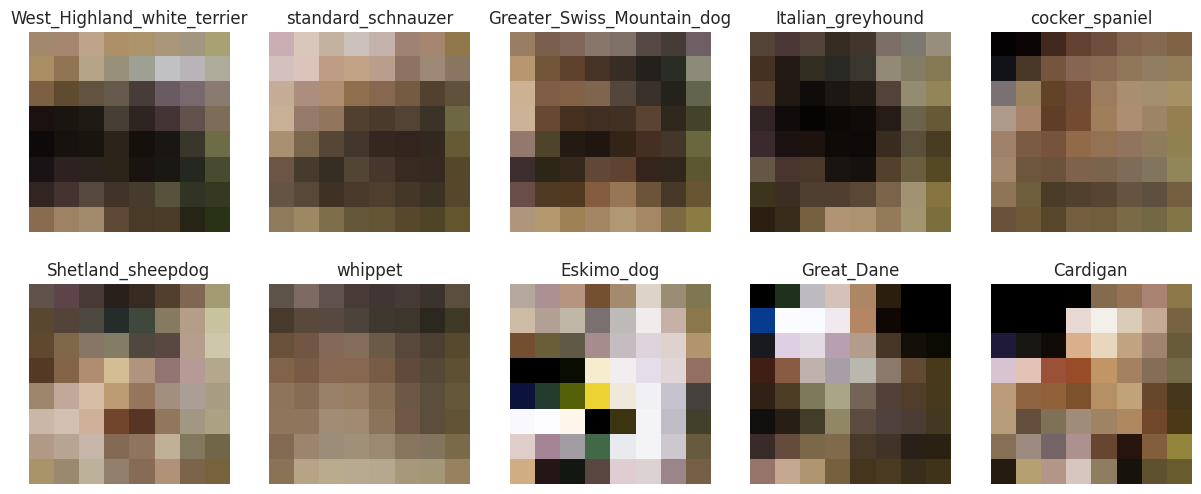


   -> Current resolution: 16 x 16 

Epoch 1/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.155     gen_loss=5.526     t=14s
Epoch 2/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.000     gen_loss=4.891     t=13s
Epoch 3/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.331     gen_loss=4.665     t=13s
Epoch 4/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.546     gen_loss=4.655     t=14s
Epoch 5/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.848     gen_loss=1.996     t=14s
Epoch 6/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.962     gen_loss=1.479     t=14s


Traceback (most recent call last):
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/srv/condor/execute/dir_108318/pymp-h9trszq8'


Epoch 7/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.470     gen_loss=1.107     t=14s
Epoch 8/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.470     gen_loss=1.017     t=14s
Epoch 9/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.443     gen_loss=1.091     t=13s
Epoch 10/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.336     gen_loss=1.140     t=14s


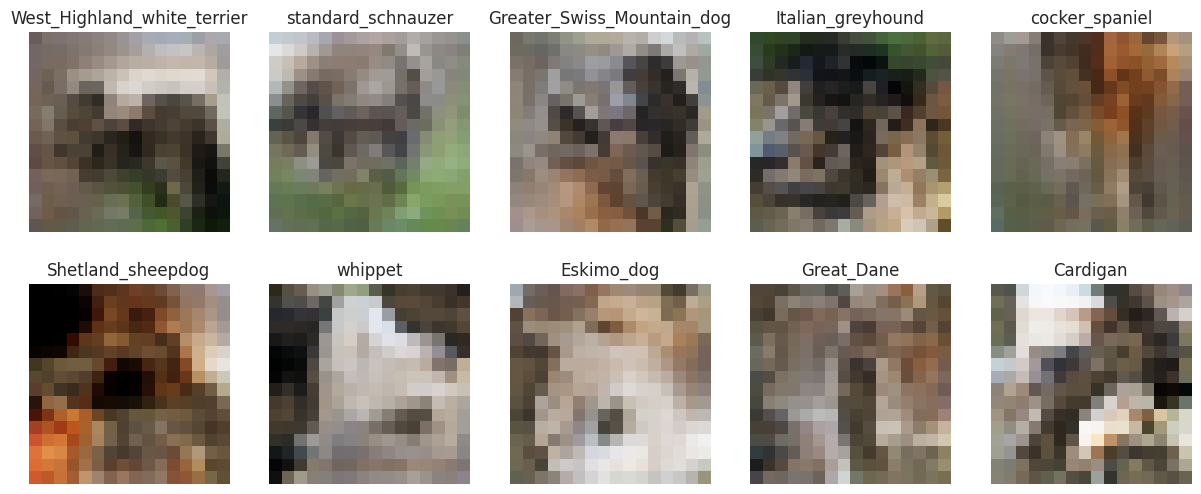

Epoch 11/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.345     gen_loss=1.126     t=14s
Epoch 12/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.268     gen_loss=1.172     t=13s
Epoch 13/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.182     gen_loss=1.232     t=14s
Epoch 14/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.167     gen_loss=1.264     t=14s
Epoch 15/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.191     gen_loss=1.244     t=13s
Epoch 16/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.159     gen_loss=1.271     t=14s
Epoch 17/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.158     gen_loss=1.271     t=14s
Epoch 18/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.145     gen_loss=1.345     t=14s
Epoch 19/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

Traceback (most recent call last):
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/sk118/miniconda3/envs/oneshotCLIP/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/srv/condor/execute/dir_108318/pymp-59jw5o9h'


Epoch 20/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.186     gen_loss=1.276     t=13s


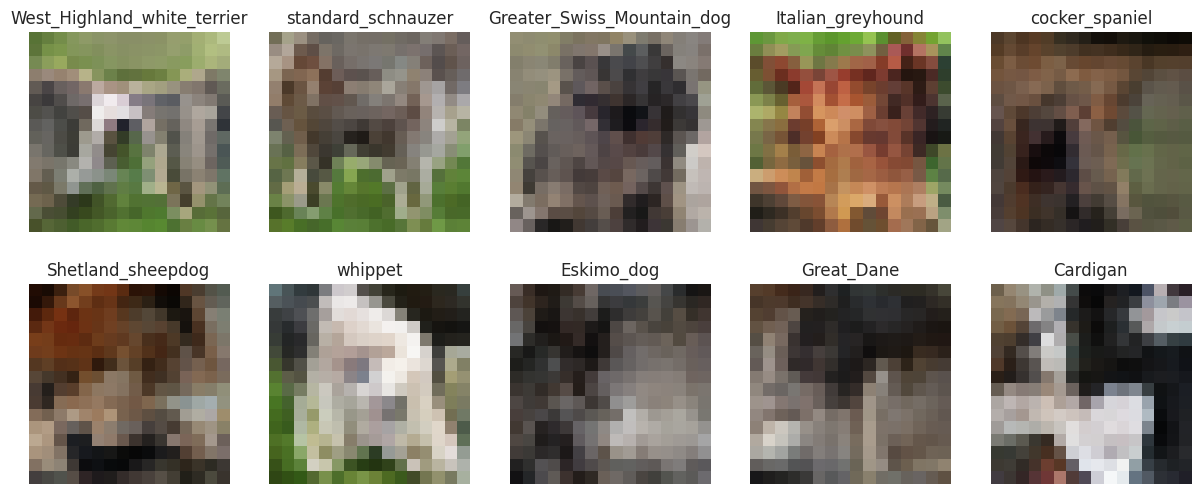


   -> Current resolution: 32 x 32 

Epoch 1/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.857     gen_loss=3.436     t=40s
Epoch 2/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.759     gen_loss=2.419     t=40s
Epoch 3/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.723     gen_loss=2.410     t=39s
Epoch 4/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.779     gen_loss=2.017     t=40s
Epoch 5/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.853     gen_loss=1.928     t=39s
Epoch 6/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.874     gen_loss=1.898     t=40s
Epoch 7/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.948     gen_loss=1.797     t=40s
Epoch 8/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.899     gen_loss=1.787     t=40s
Epoch 9/40     lr_g=6.0e-03     lr_d=6.0e-0

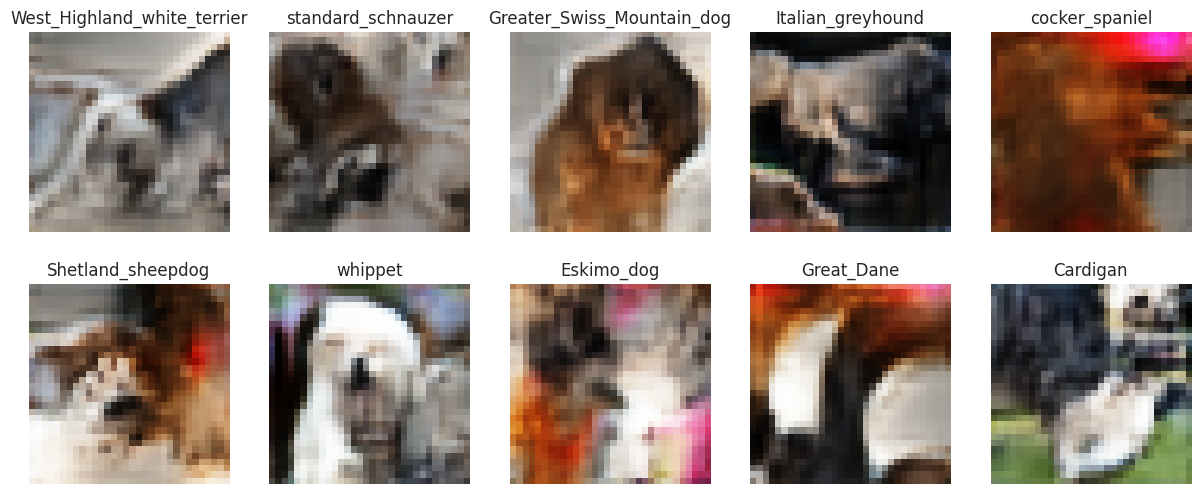

Epoch 11/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.909     gen_loss=1.722     t=39s
Epoch 12/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.854     gen_loss=1.822     t=40s
Epoch 13/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.836     gen_loss=1.842     t=40s
Epoch 14/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.848     gen_loss=1.845     t=39s
Epoch 15/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.863     gen_loss=1.819     t=40s
Epoch 16/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.837     gen_loss=1.961     t=40s
Epoch 17/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.879     gen_loss=1.857     t=40s
Epoch 18/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.823     gen_loss=1.973     t=40s
Epoch 19/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

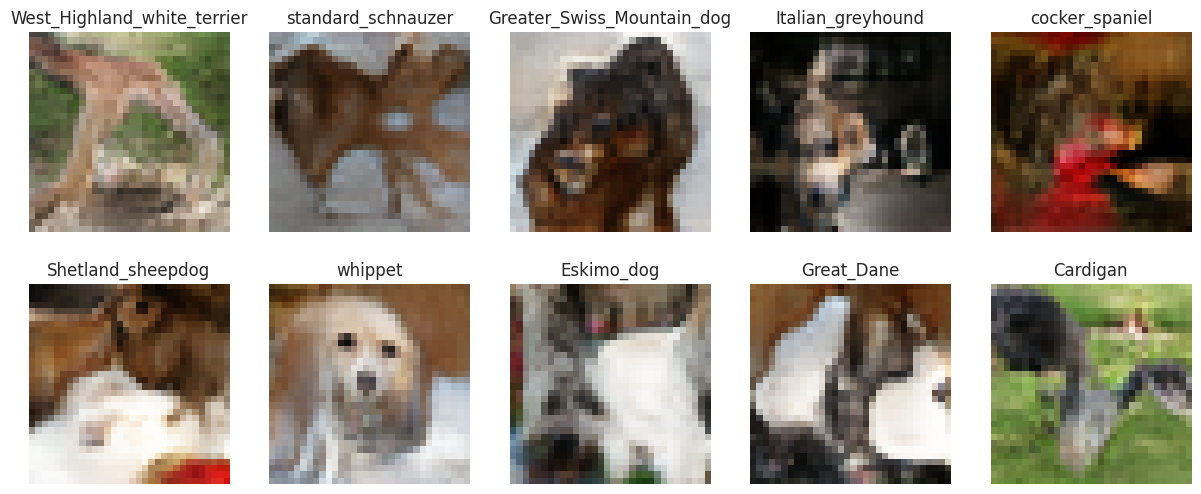

Epoch 21/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.788     gen_loss=2.098     t=39s
Epoch 22/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.776     gen_loss=2.095     t=39s
Epoch 23/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.737     gen_loss=2.186     t=40s
Epoch 24/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.725     gen_loss=2.204     t=40s
Epoch 25/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.718     gen_loss=2.253     t=40s
Epoch 26/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.717     gen_loss=2.270     t=40s
Epoch 27/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.707     gen_loss=2.351     t=40s
Epoch 28/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.719     gen_loss=2.275     t=40s
Epoch 29/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

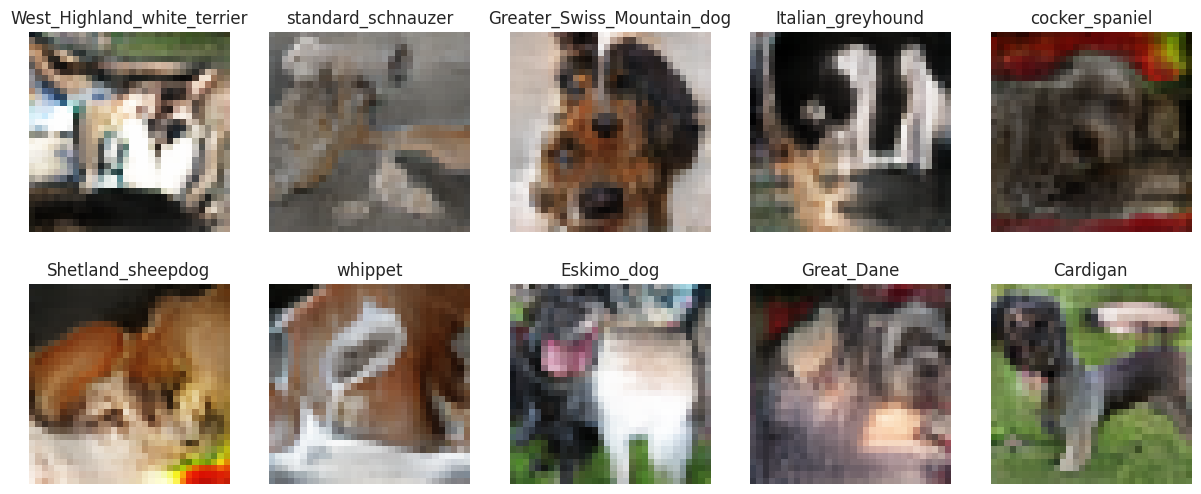

Epoch 31/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.684     gen_loss=2.493     t=40s
Epoch 32/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.662     gen_loss=2.553     t=40s
Epoch 33/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.702     gen_loss=2.585     t=39s
Epoch 34/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.726     gen_loss=2.439     t=40s
Epoch 35/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.671     gen_loss=2.525     t=40s
Epoch 36/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.682     gen_loss=2.619     t=40s
Epoch 37/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.641     gen_loss=2.688     t=40s
Epoch 38/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.656     gen_loss=2.657     t=40s
Epoch 39/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

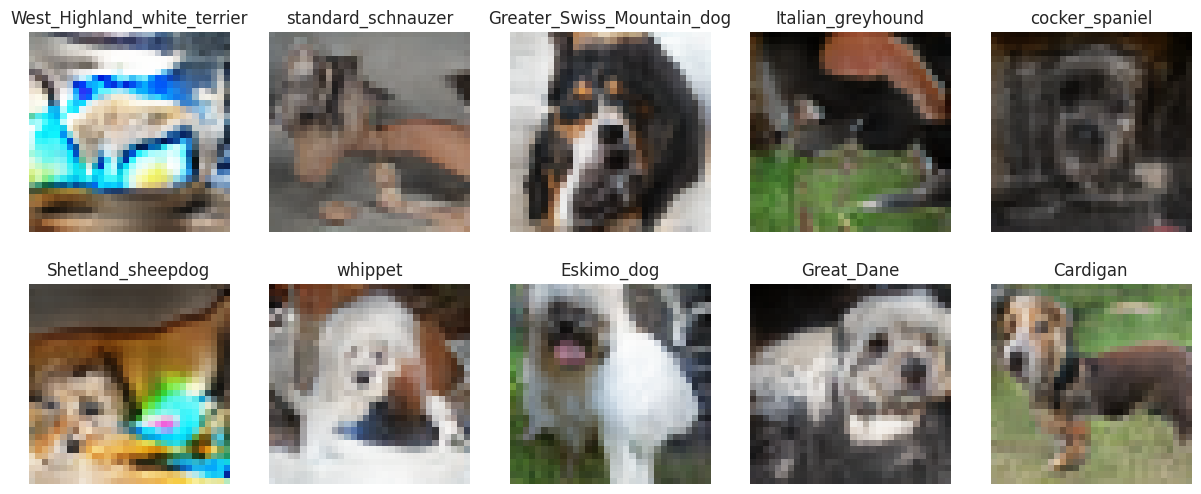


   -> Current resolution: 64 x 64 

Epoch 1/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.967     gen_loss=2.753     t=88s
Epoch 2/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.624     gen_loss=2.782     t=87s
Epoch 3/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.724     gen_loss=2.599     t=87s
Epoch 4/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.648     gen_loss=3.003     t=87s
Epoch 5/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.646     gen_loss=3.030     t=87s
Epoch 6/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.673     gen_loss=2.921     t=87s
Epoch 7/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.640     gen_loss=3.039     t=87s
Epoch 8/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.689     gen_loss=2.788     t=87s
Epoch 9/100     lr_g=6.0e-03     lr

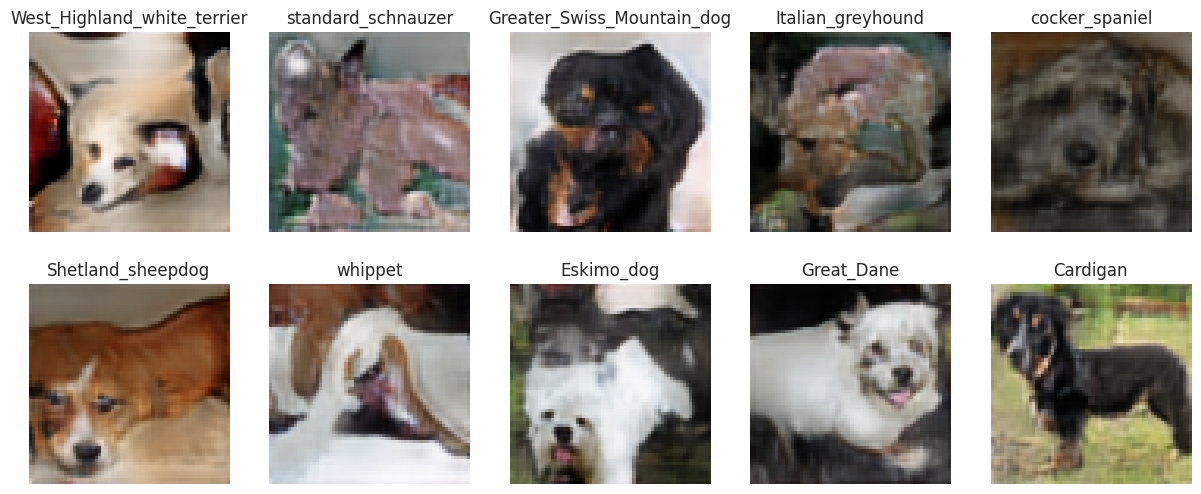

Epoch 11/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.649     gen_loss=2.952     t=87s
Epoch 12/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.642     gen_loss=2.990     t=87s
Epoch 13/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.661     gen_loss=2.997     t=87s
Epoch 14/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.652     gen_loss=2.950     t=87s
Epoch 15/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.642     gen_loss=2.963     t=87s
Epoch 16/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.590     gen_loss=3.157     t=87s
Epoch 17/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.623     gen_loss=3.166     t=87s
Epoch 18/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.613     gen_loss=3.153     t=87s
Epoch 19/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

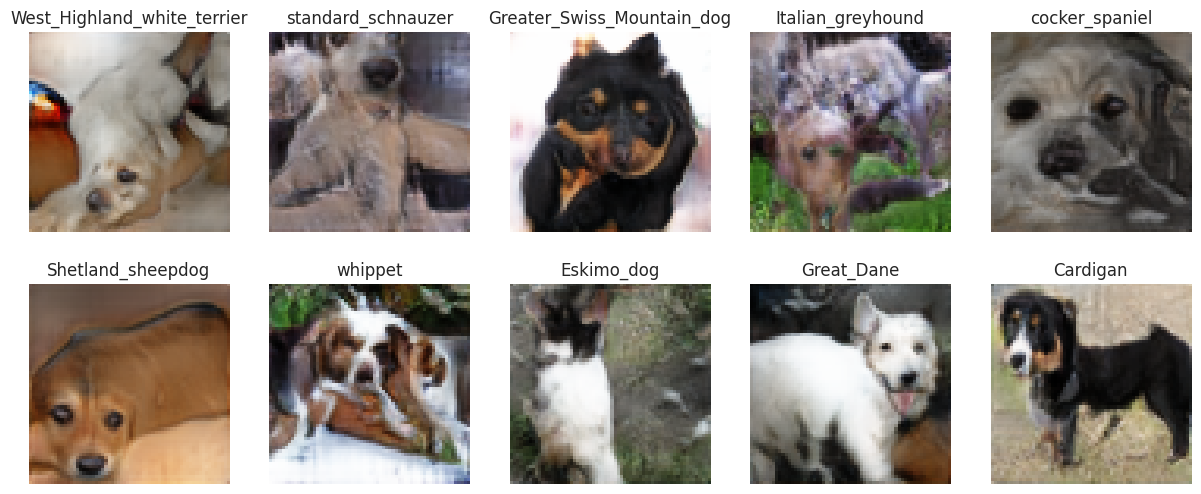

Epoch 21/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.569     gen_loss=3.466     t=87s
Epoch 22/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.583     gen_loss=3.424     t=86s
Epoch 23/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.555     gen_loss=3.388     t=87s
Epoch 24/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.519     gen_loss=3.615     t=87s
Epoch 25/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.567     gen_loss=3.637     t=86s


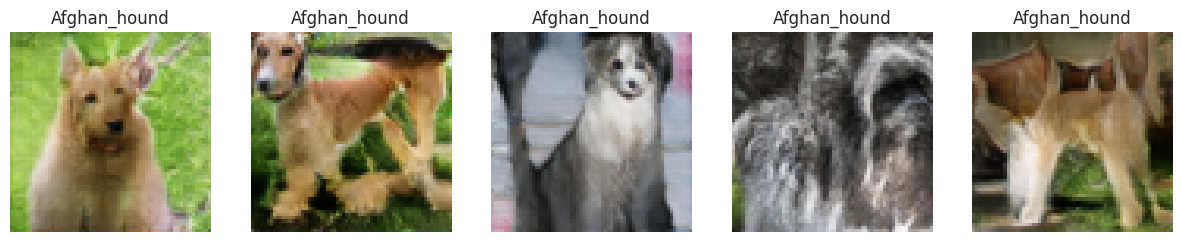

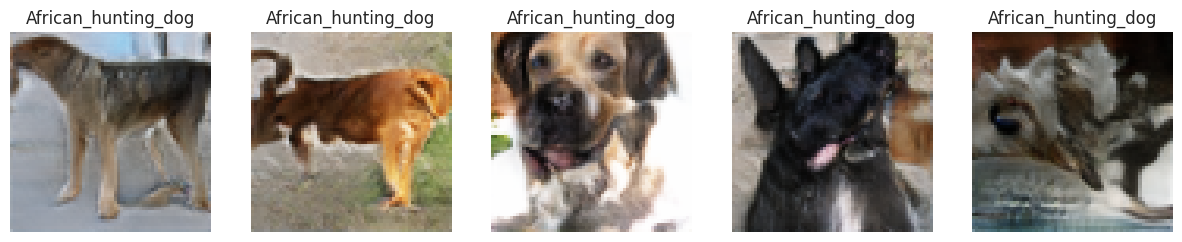

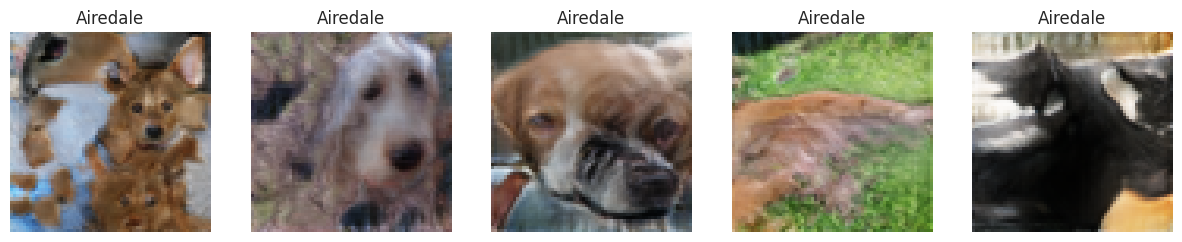

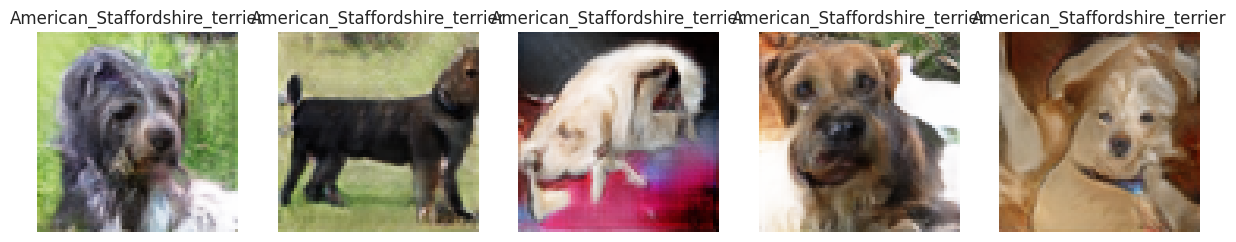

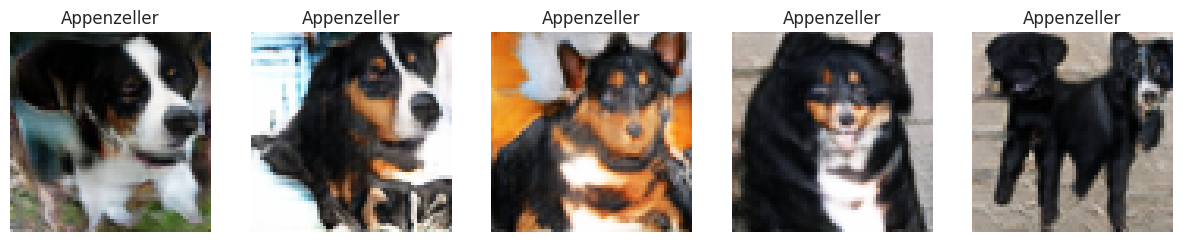

Epoch 26/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.544     gen_loss=3.490     t=87s
Epoch 27/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.503     gen_loss=3.635     t=87s
Epoch 28/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.548     gen_loss=3.574     t=87s
Epoch 29/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.557     gen_loss=3.636     t=87s
Epoch 30/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.491     gen_loss=3.672     t=87s


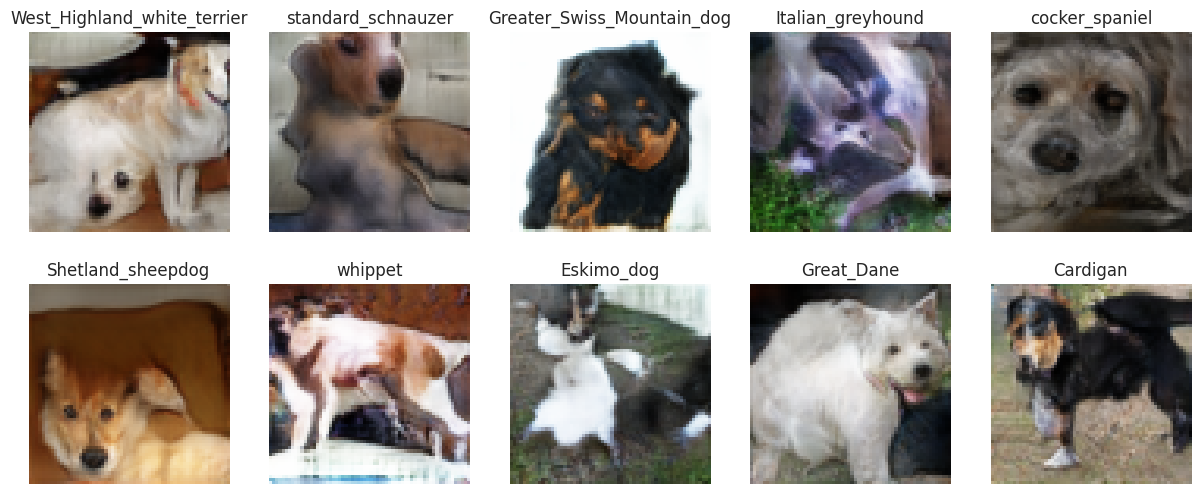

Epoch 31/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.512     gen_loss=3.635     t=86s
Epoch 32/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.496     gen_loss=3.674     t=87s
Epoch 33/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.489     gen_loss=3.742     t=87s
Epoch 34/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.490     gen_loss=3.801     t=87s
Epoch 35/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.513     gen_loss=3.907     t=87s
Epoch 36/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.519     gen_loss=3.845     t=87s
Epoch 37/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.482     gen_loss=3.856     t=88s
Epoch 38/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.484     gen_loss=3.912     t=87s
Epoch 39/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

In [ ]:
infos = pro_gan.train(
    dataset=dataset,
    epochs=num_epochs,
    fade_in_percentage=fade_ins,
    batch_sizes=batch_sizes,
    ema_decays=ema_decays,
    verbose=1
)

In [ ]:
save_model_weights(pro_gan.gen, "./checkpoints_/normal/gen_weights.pt")
save_model_weights(pro_gan.gen_shadow, "./checkpoints_/normal/gen_shadow_weights.pt")
save_model_weights(pro_gan.dis, "./checkpoints_/normal/dis_weights.pt")

## Generated Dogs using projection embedding

In [30]:
depth = 5
latent_size = 256

loss = Hinge
lr_d = 6e-3
lr_g = 6e-3

pro_gan = ConditionalProGAN(num_classes=nb_classes, depth=depth, latent_size=latent_size, 
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [31]:
load_model_weights(pro_gan.gen, "./checkpoints_/normal/gen_weights.pt")
load_model_weights(pro_gan.gen_shadow, "./checkpoints_/normal/gen_shadow_weights.pt")
load_model_weights(pro_gan.dis, "./checkpoints_/normal/dis_weights.pt")

-> Loading weights from ./checkpoints_/normal/gen_weights.pt
-> Loading weights from ./checkpoints_/normal/gen_shadow_weights.pt
-> Loading weights from ./checkpoints_/normal/dis_weights.pt


DataParallel(
  (module): ConditionalDiscriminator(
    (noise): GaussianNoise()
    (final_block): ConDisFinalBlock(
      (batch_discriminator): MinibatchStdDev()
      (conv_1): _equalized_conv2d(256, 257, 3, 3)
      (conv_2): _equalized_conv2d(256, 256, 4, 4)
      (conv_3): _equalized_conv2d(1, 256, 1, 1)
      (label_embedder): Embedding(120, 256, max_norm=1)
      (lrelu): LeakyReLU(negative_slope=0.2)
      (ft_matching_dense): Linear(in_features=512, out_features=128, bias=True)
    )
    (layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): DisGeneralConvBlock(
          (conv_1): _equalized_conv2d(256, 256, 3, 3)
          (conv_2): _equalized_conv2d(256, 256, 3, 3)
          (downSampler): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (lrelu): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Sequential(
        (0): DisGeneralConvBlock(
          (conv_1): _equalized_conv2d(128, 128, 3, 3)
          (conv_2): _equalized_conv2d(256, 128, 3, 3)


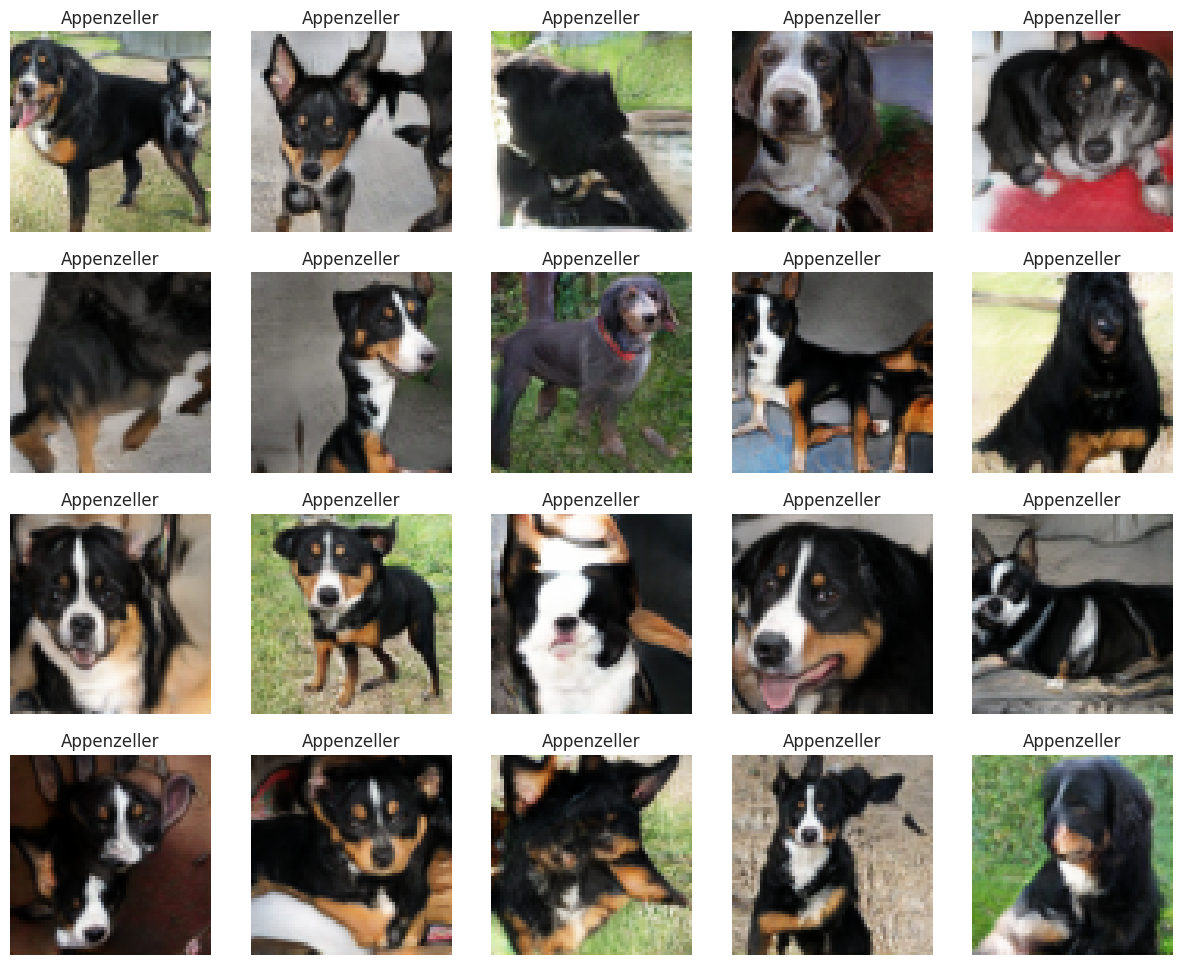

In [36]:
_ = pro_gan.generate(n_plot=20, n=20, races = torch.from_numpy(np.array([4] * 20)).long())

# Experiments

In [32]:
pro_gan = ConditionalProGAN(num_classes=nb_classes, depth=depth, latent_size=latent_size, 
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [33]:
load_model_weights(pro_gan.gen, "./checkpoints_/normal/gen_weights.pt")
load_model_weights(pro_gan.gen_shadow, "./checkpoints_/normal/gen_shadow_weights.pt")
load_model_weights(pro_gan.dis, "./checkpoints_/normal/dis_weights.pt")

-> Loading weights from ./checkpoints_/normal/gen_weights.pt
-> Loading weights from ./checkpoints_/normal/gen_shadow_weights.pt
-> Loading weights from ./checkpoints_/normal/dis_weights.pt


DataParallel(
  (module): ConditionalDiscriminator(
    (noise): GaussianNoise()
    (final_block): ConDisFinalBlock(
      (batch_discriminator): MinibatchStdDev()
      (conv_1): _equalized_conv2d(256, 257, 3, 3)
      (conv_2): _equalized_conv2d(256, 256, 4, 4)
      (conv_3): _equalized_conv2d(1, 256, 1, 1)
      (label_embedder): Embedding(120, 256, max_norm=1)
      (lrelu): LeakyReLU(negative_slope=0.2)
      (ft_matching_dense): Linear(in_features=512, out_features=128, bias=True)
    )
    (layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): DisGeneralConvBlock(
          (conv_1): _equalized_conv2d(256, 256, 3, 3)
          (conv_2): _equalized_conv2d(256, 256, 3, 3)
          (downSampler): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (lrelu): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Sequential(
        (0): DisGeneralConvBlock(
          (conv_1): _equalized_conv2d(128, 128, 3, 3)
          (conv_2): _equalized_conv2d(256, 128, 3, 3)


## Fixed C, varying Z

In [34]:
latent_size = 256 
num_steps = 7

4 5
4 5
4 5
4 5
4 5
4 5
4 5


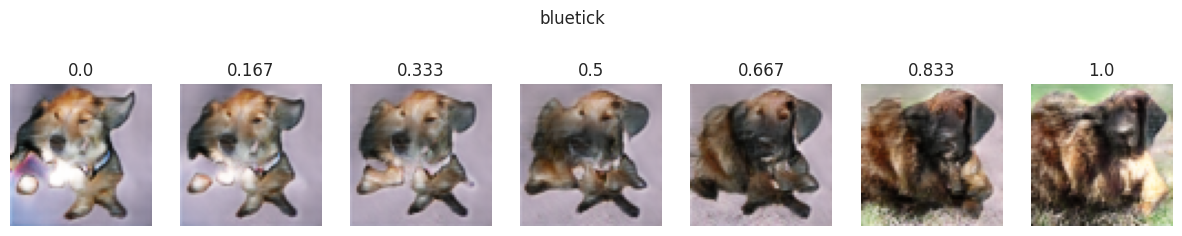

In [198]:
noise_1 = th.randn(1, latent_size - nb_classes).cuda()
noise_2 = th.randn(1, latent_size - nb_classes).cuda()

race_index = 80
race = torch.from_numpy(np.array([race_index])).reshape(1,1)

pro_gan.getZInterpolation(noise_1, noise_2, num_steps, race)

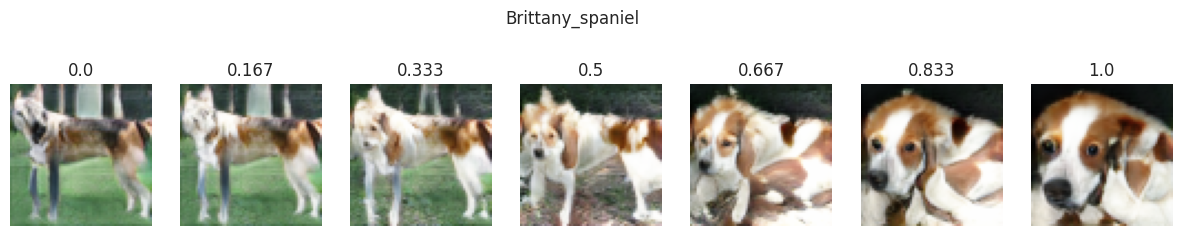

In [37]:
noise_1 = th.randn(1, latent_size - nb_classes).cuda()
noise_2 = th.randn(1, latent_size - nb_classes).cuda()

race_index = 14
race = torch.from_numpy(np.array([race_index])).reshape(1,1)

pro_gan.getZInterpolation(noise_1, noise_2, num_steps, race)

## Fixed Z, varying C

4 5
4 5
4 5
4 5
4 5
4 5
4 5


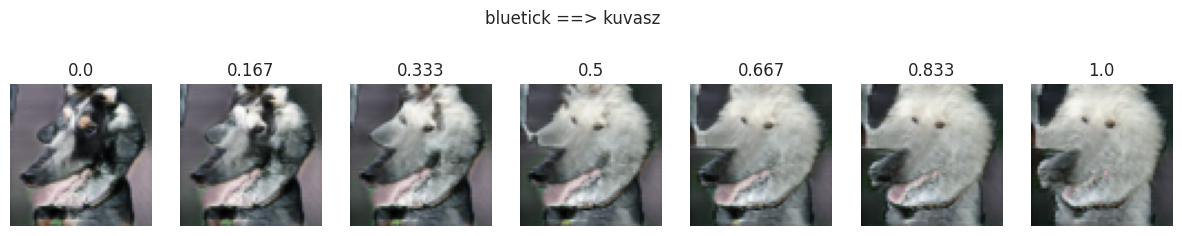

In [204]:
latent_size = 256 
num_classes = 120
num_steps = 7

noise = th.randn(1, latent_size - num_classes).cuda()

c1 = 80
c2 = 100

race_1 = torch.from_numpy(np.array([c1])).reshape(1,1)
race_2 = torch.from_numpy(np.array([c2])).reshape(1,1)

pro_gan.getCInterpolation(race_1, race_2, noise, num_steps)

4 5
4 5
4 5
4 5
4 5
4 5
4 5


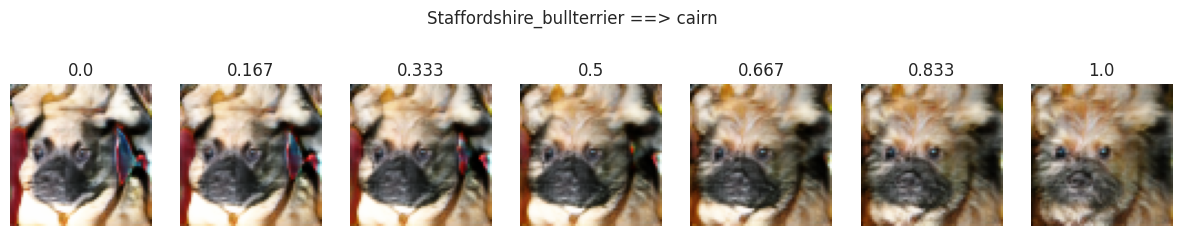

In [218]:
latent_size = 256 
num_classes = 120
num_steps = 7

noise = th.randn(1, latent_size - num_classes).cuda()

c1 = 65
c2 = 85

race_1 = torch.from_numpy(np.array([c1])).reshape(1,1)
race_2 = torch.from_numpy(np.array([c2])).reshape(1,1)

pro_gan.getCInterpolation(race_1, race_2, noise, num_steps)

## Varying both Z and C

4 5
4 5
4 5
4 5
4 5
4 5
4 5


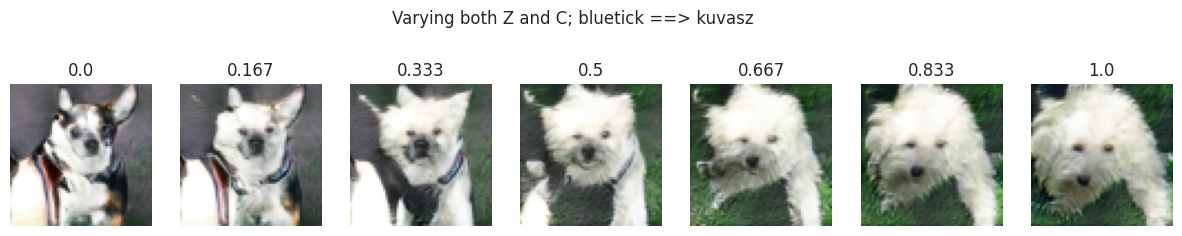

In [228]:
latent_size = 256 
num_classes = 120
num_steps = 7

noise_1 = th.randn(1, latent_size - nb_classes).cuda()
noise_2 = th.randn(1, latent_size - nb_classes).cuda()

c1 = 80
c2 = 100

race_1 = torch.from_numpy(np.array([c1])).reshape(1,1)
race_2 = torch.from_numpy(np.array([c2])).reshape(1,1)

pro_gan.getZCInterpolation(noise_1, noise_2, race_1, race_2, num_steps)

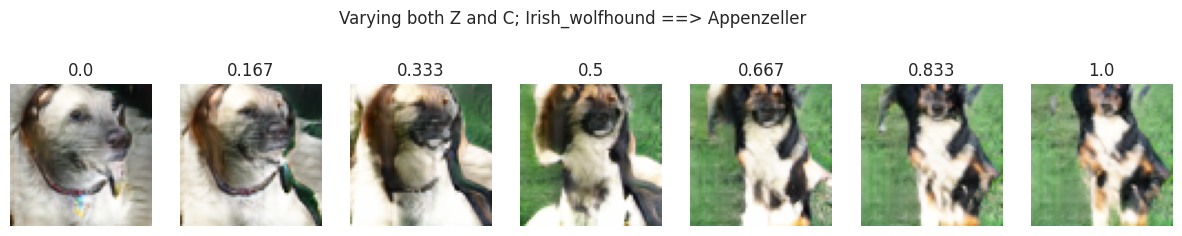

In [61]:
noise_1 = th.randn(1, latent_size - nb_classes).cuda()
noise_2 = th.randn(1, latent_size - nb_classes).cuda()

c1 = 36
c2 = 4

race_1 = torch.from_numpy(np.array([c1])).reshape(1,1)
race_2 = torch.from_numpy(np.array([c2])).reshape(1,1)

pro_gan.getZCInterpolation(noise_1, noise_2, race_1, race_2, num_steps)